The code was adapted from: https://www.pymc.io/projects/examples/en/latest/case_studies/BART_introduction.html

In [1]:
import warnings

from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
# import pymc_bart as pmb
import bart_rs as pmb

warnings.filterwarnings(action="ignore", category=FutureWarning)

print(f"Running on PyMC v{pm.__version__}")
# print(f"Running on PyMC v{pmb.__version__}")

Running on PyMC v5.16.2


/Users/gabestechschulte/miniforge3/envs/bart_rs/lib/python3.12/site-packages/pytensor/tensor/random/op.py:94: FutureWarning: ndims_params is deprecated. Provide signature instead.
  warnings.warn(


In [2]:
import pytensor.tensor as pt
from pytensor.tensor.random.op import RandomVariable

In [3]:
RANDOM_SEED = 8457
rng = np.random.RandomState(RANDOM_SEED)

## Sine wave

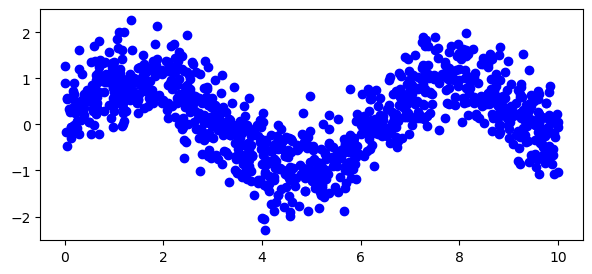

In [35]:
np.random.seed(0)
n = 1_000
X = np.random.uniform(0, 10, n)
Y = np.sin(X) + np.random.normal(0, 0.5, n)
data = pd.DataFrame(data={'Feature': X.flatten(), 'Y': Y})

plt.figure(figsize=(7, 3))
plt.scatter(data['Feature'], data['Y'], c='blue', label='Data')
plt.show();

In [36]:
# Using PyMC compound step
with pm.Model() as model:
    sigma = pm.HalfNormal("sigma", 5.)
    mu = pmb.BART("mu", X.reshape(-1, 1), Y, m=100)
    y = pm.Normal("y", mu, sigma=sigma, observed=Y)
    idata = pm.sample(
        tune=300,
        draws=500,
        step=[pmb.PGBART([mu], batch=(0.1, 0.9999), num_particles=10)],
        random_seed=42,
        )

initial_values              : {'sigma_log__': array(1.60943791), 'mu': array([0.18333212, 0.18333212, 0.18333212, 0.18333212, 0.18333212,
       0.18333212, 0.18333212, 0.18333212, 0.18333212, 0.18333212,
       0.18333212, 0.18333212, 0.18333212, 0.18333212, 0.18333212,
       0.18333212, 0.18333212, 0.18333212, 0.18333212, 0.18333212,
       0.18333212, 0.18333212, 0.18333212, 0.18333212, 0.18333212,
       0.18333212, 0.18333212, 0.18333212, 0.18333212, 0.18333212,
       0.18333212, 0.18333212, 0.18333212, 0.18333212, 0.18333212,
       0.18333212, 0.18333212, 0.18333212, 0.18333212, 0.18333212,
       0.18333212, 0.18333212, 0.18333212, 0.18333212, 0.18333212,
       0.18333212, 0.18333212, 0.18333212, 0.18333212, 0.18333212,
       0.18333212, 0.18333212, 0.18333212, 0.18333212, 0.18333212,
       0.18333212, 0.18333212, 0.18333212, 0.18333212, 0.18333212,
       0.18333212, 0.18333212, 0.18333212, 0.18333212, 0.18333212,
       0.18333212, 0.18333212, 0.18333212, 0.18333212, 0.1

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>PGBART: [mu]
>NUTS: [sigma]


/Users/gabestechschulte/miniforge3/envs/bart_rs/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 300 tune and 500 draw iterations (1_200 + 2_000 draws total) took 12 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.


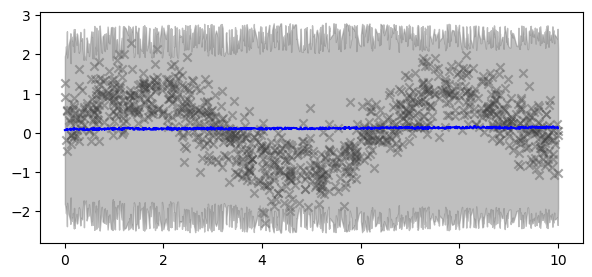

In [37]:
y_hat = idata["posterior"]["mu"].mean(("chain", "draw"))
std_hat = idata["posterior"]["mu"].std(("chain", "draw"))
idx_sort = np.argsort(X.flatten())

plt.figure(figsize=(7, 3))
plt.scatter(X.flatten()[idx_sort], Y[idx_sort], marker="x", color="black", alpha=0.35)
plt.plot(X.flatten()[idx_sort], y_hat[idx_sort], color="blue")
plt.fill_between(
    X.flatten()[idx_sort],
    y_hat[idx_sort] + std_hat[idx_sort] * 2,
    y_hat[idx_sort] - std_hat[idx_sort] * 2,
    color="grey",
    alpha=0.5
)
plt.show()

## Coal mining example

In [4]:
try:
    coal = np.loadtxt(Path("..", "data", "coal.csv"))
except FileNotFoundError:
    coal = np.loadtxt(pm.get_data("coal.csv"))

In [5]:
# discretize data
years = int(coal.max() - coal.min())
bins = years // 4
hist, x_edges = np.histogram(coal, bins=bins)
# compute the location of the centers of the discretized data
x_centers = x_edges[:-1] + (x_edges[1] - x_edges[0]) / 2
# xdata needs to be 2D for BART
x_data = x_centers[:, None]
# express data as the rate number of disaster per year
y_data = hist / 4

In [6]:
with pm.Model() as model_coal:
    mu_ = pmb.BART("μ_", X=x_data, Y=np.log(y_data), m=20, alpha=0.95, beta=2.0)
    mu = pm.Deterministic("mu", pm.math.exp(mu_))
    y_pred = pm.Poisson("y_pred", mu=mu, observed=y_data)
    # y = pm.Normal("y", mu_, sigma=1., observed=y_data)

    idata_coal = pm.sample(
        tune=300,
        draws=500,
        step=[pmb.PGBART([mu_], num_particles=10)],
        random_seed=42,
        )

['ContinuousSplit']


Multiprocess sampling (4 chains in 4 jobs)
PGBART: [μ_]


/Users/gabestechschulte/miniforge3/envs/bart_rs/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 300 tune and 500 draw iterations (1_200 + 2_000 draws total) took 1 seconds.


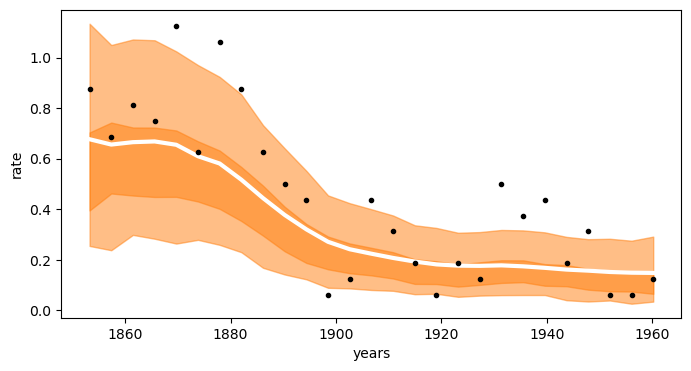

In [7]:
_, ax = plt.subplots(figsize=(8, 4))

rates = idata_coal.posterior["mu"] / 4
rate_mean = rates.mean(dim=["draw", "chain"])
ax.plot(x_centers, rate_mean, "w", lw=3)
ax.plot(x_centers, y_data / 4, "k.")
az.plot_hdi(x_centers, rates, smooth=False)
az.plot_hdi(x_centers, rates, hdi_prob=0.5, smooth=False, plot_kwargs={"alpha": 0})
# ax.plot(coal, np.zeros_like(coal) - 0.5, "k|")
ax.set_xlabel("years")
ax.set_ylabel("rate");

initial_values              : {'mu_': array([1.76851852, 1.76851852, 1.76851852, 1.76851852, 1.76851852,
       1.76851852, 1.76851852, 1.76851852, 1.76851852, 1.76851852,
       1.76851852, 1.76851852, 1.76851852, 1.76851852, 1.76851852,
       1.76851852, 1.76851852, 1.76851852, 1.76851852, 1.76851852,
       1.76851852, 1.76851852, 1.76851852, 1.76851852, 1.76851852,
       1.76851852, 1.76851852])}
vars (to keep non-shared)   : [mu_]
shared                      : {}
out_vars                    : [Add.0]
new_out                     : [Add.0]
new_joined_inputs           : joined_inputs
vars: [mu_]
shared: {}


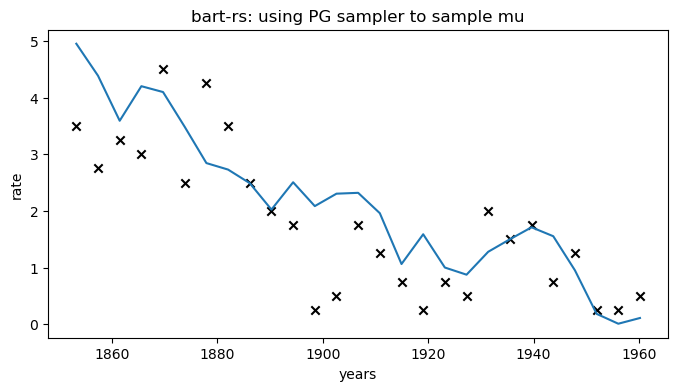

In [27]:
with pm.Model() as model_coal:
    mu_ = pmb.BART("mu_", X=x_data, Y=y_data, m=50, alpha=0.99, beta=1.0)
    y = pm.Normal("y", mu_, sigma=1., observed=y_data)
    step = pmb.PGBART([mu_], num_particles=10)

trees, time = step.astep(1)

_, ax = plt.subplots(figsize=(8, 4))

ax.scatter(x_data, y_data, color="black", marker="x")
ax.plot(x_centers, trees)
# ax.plot(coal, np.zeros_like(coal) - 0.5, "k|")
ax.set_xlabel("years")
ax.set_ylabel("rate")
plt.title("bart-rs: using PG sampler to sample mu");

## Bike sharing example

In [28]:
try:
    bikes = pd.read_csv(Path("..", "data", "bikes.csv"))
except FileNotFoundError:
    bikes = pd.read_csv(pm.get_data("bikes.csv"))

X = bikes[["hour", "temperature", "humidity", "workingday"]]
Y = bikes["count"]

In [ ]:
with pm.Model() as model_bikes:
    alpha = pm.Exponential("alpha", 1)
    mu = pmb.BART("mu", X, np.log(Y), m=50)
    y = pm.NegativeBinomial("y", mu=pm.math.exp(mu), alpha=alpha, observed=Y)
    idata_bikes = pm.sample(
        tune=300,
        draws=500,
        step=[pmb.PGBART([mu], num_particles=10)],
        random_seed=42,
        )
    posterior_predictive_oos_regression_train = pm.sample_posterior_predictive(
        trace=idata_bikes, random_seed=RANDOM_SEED
    )

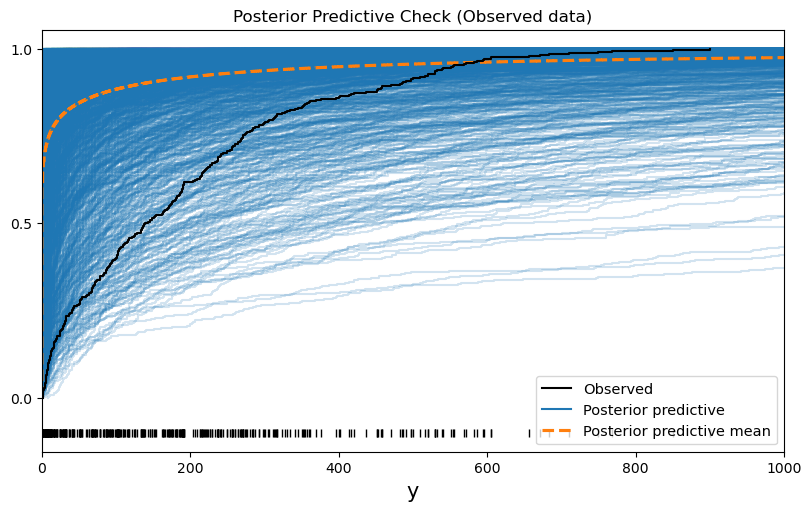

In [32]:
fig, ax = plt.subplots(
    nrows=1, ncols=1, figsize=(8, 5), sharex=True, sharey=True, layout="constrained"
)
az.plot_ppc(data=posterior_predictive_oos_regression_train, kind="cumulative", observed_rug=True, ax=ax)
ax.set(title="Posterior Predictive Check (Observed data)", xlim=(0, 1_000));

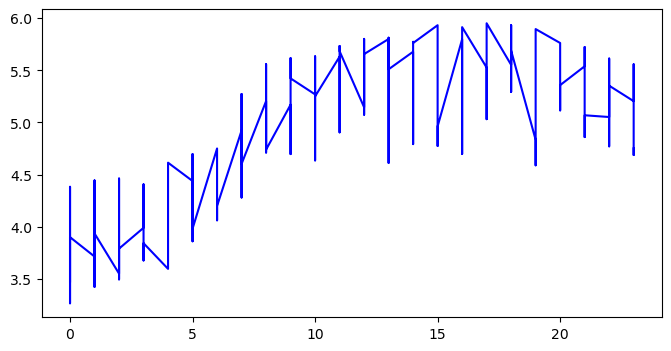

In [25]:
hour = X[:, 0]
num_bikes = Y

mu = idata_bikes["posterior"]["mu"].mean(("chain", "draw")).to_numpy()
std = idata_bikes["posterior"]["mu"].std(("chain", "draw")).to_numpy()

plt.figure(figsize=(8, 4))
# plt.scatter(hour, num_bikes, color="black", marker="x", alpha=0.5)
plt.plot(hour, mu, color="blue");

## Asymmetric LaPlace

In [33]:
bmi = pd.read_csv(pm.get_data("bmi.csv"))
y = bmi.bmi.values
X = bmi.age.values[:, None]
y_stack = np.stack([bmi.bmi.values] * 3)
quantiles = np.array([[0.1, 0.5, 0.9]]).T

In [ ]:
with pm.Model() as model:
    mu = pmb.BART("mu", X, y, shape=(3, 7294))
    sigma = pm.HalfNormal("σ", 5)
    obs = pm.AsymmetricLaplace("obs", mu=mu, b=sigma, q=quantiles, observed=y_stack)
    idata = pm.sample(tune=300, draws=500, compute_convergence_checks=False, random_seed=RANDOM_SEED)

## Modeling heteroskedasticity with BART

In [5]:
df = pd.read_csv(pm.get_data("marketing.csv"), sep=";", decimal=",")

X = df["youtube"].to_numpy().reshape(-1, 1)
Y = df["sales"].to_numpy()

n_obs = df.shape[0]

In [ ]:
with pm.Model() as model_marketing_full:
    w = pmb.BART("w", X=X, Y=np.log(Y), m=100, shape=(2, n_obs))
    y = pm.Gamma("y", mu=pm.math.exp(w[0]), sigma=pm.math.exp(w[1]), observed=Y)

pm.model_to_graphviz(model=model_marketing_full)

In [ ]:
with model_marketing_full:
    idata_marketing_full = pm.sample(2000, random_seed=rng, compute_convergence_checks=False)
    posterior_predictive_marketing_full = pm.sample_posterior_predictive(
        trace=idata_marketing_full, random_seed=rng
    )